# Propensity Modeling

In [1]:
import numpy as np
import pandas as pd
import pickle
# import urllib
# from tqdm import tqdm, trange, tqdm_pandas
# import os
# from user_agents import parse
# import datetime
from time import time
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
# pd.set_option('display.max_columns', 1000)

##  1. Data

In [2]:
%%time
with open( "../Data/Feature_Engineering/df_features_normalize.p", "rb" ) as f:
    df_features = pickle.load(f)

with open( "../Data/Feature_Engineering/df_label.p", "rb" ) as f:
    df_label = pickle.load(f)

CPU times: user 694 ms, sys: 4.84 s, total: 5.54 s
Wall time: 2min 49s


In [3]:
%%time
X = df_features
Y = df_label

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


### 1.1 Split data to training set, validation set and test set

In [4]:
print(X.shape)
bar_80 = np.floor(X.shape[0]*0.8).astype(int)
bar_80=bar_80+1
bar_80

(220047, 2357)


176038

In [5]:
X_train=X[:bar_80]
Y_train=Y[:bar_80]
X_test=X[bar_80:]
Y_test=Y[bar_80:]

## 2.0 Feature Selection

In [6]:
%%time
clf=RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
                           oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                           class_weight=None)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 74.1 µs


In [7]:
%%time
clf.fit(X_train, Y_train)

CPU times: user 33.7 s, sys: 466 ms, total: 34.2 s
Wall time: 8.55 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [8]:
clf.feature_importances_ 

array([ 0.02365827,  0.03745809,  0.02031648, ...,  0.0005593 ,
        0.00011054,  0.00068568])

In [9]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

(220047, 81)

In [10]:
X_train=X_new[:bar_80]
Y_train=Y[:bar_80]
X_test=X_new[bar_80:]
Y_test=Y[bar_80:]

## 2. Random Forest Classifier


|  Parameters  |  Explanation |  
|---|---|---|---|---|
|  n_estimators | The number of trees in the forest  |   
| criterion  | The function to measure the quality of a split.  |   
|  max_depth | The number of features to consider when looking for the best split  |   
|  max_depth | The maximum depth of the tree.  |   
|  min_samples_split |   |  
| min_samples_leaf  |   |  
| max_features  |   |  
| max_leaf_nodes  |   |   
| bootstrap  |   |   
| oob_score  |   |   
|  n_jobs |   |   
|  random_state |   |   
|  verbose |   |  
|  warm_start |   |   
|  class_weight |   |   




### 2.1 Random Search

In [13]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [14]:
clf = RandomForestClassifier(n_estimators=50)

param_dist = {"max_depth": [3, 5, 8, 15, 25, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

n_iter_search = 80
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_train, Y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

KeyboardInterrupt: 

In [30]:
Y_pred=random_search.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))
print('---------------------------------------------------------------------------------------------------------')
report(random_search.cv_results_)

Classification accuracy rate is:  0.939262423595
---------------------------------------------------------------------------------------------------------
Model with rank: 1
Mean validation score: 0.940 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_features': 10, 'min_samples_leaf': 3, 'bootstrap': False, 'max_depth': 25, 'min_samples_split': 15}

Model with rank: 2
Mean validation score: 0.939 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_features': 10, 'min_samples_leaf': 6, 'bootstrap': False, 'max_depth': 25, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.939 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_features': 9, 'min_samples_leaf': 2, 'bootstrap': False, 'max_depth': None, 'min_samples_split': 9}



---

### 2.2 Model Training

In [15]:
clf=RandomForestClassifier(n_estimators=1000,criterion='gini',max_features= 10, 
                           min_samples_leaf=3, bootstrap= False, max_depth= 25, 
                           min_samples_split= 15)

In [16]:
%%time
clf.fit(X_train, Y_train)

CPU times: user 8min 20s, sys: 257 ms, total: 8min 20s
Wall time: 8min 20s


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=25, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

---

**Save Model**

In [36]:
%%time
path = '../Data/Propensity_Modeling/RandomForest_Op00.pkl'
joblib.dump(random_search, path)

# clf=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
#                            min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
#                            oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
#                            class_weight=None)

CPU times: user 40 ms, sys: 19 ms, total: 59 ms
Wall time: 58.7 ms


In [40]:
Y_predict=clf.predict(X_test)

### 2.3 Load Model

In [11]:
%%time
# load the model from disk
path = '../Data/Propensity_Modeling/RandomForest_Op00.pkl'
Random_Forest_Classifier = joblib.load(path)

# result = loaded_model.score(X_test, Y_test)
# print(result)

CPU times: user 30 ms, sys: 34 ms, total: 64 ms
Wall time: 64.4 ms


## 3. Result Analysis

### 3.1 Accuracy Rate

In [17]:
Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.93937603672


In [38]:
# Original Result:
Y_pred = clf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.939216978345


In [39]:
# Result with 100 trees
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96     37065
          1       0.86      0.74      0.79      6944

avg / total       0.94      0.94      0.94     44009



In [40]:
sum(Y_test)/len(Y_test)

0.15778590742802609

### 3.2 Confusion matrix

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix is:
 [[36226   839]
 [ 1836  5108]]

Plot of Confusion Matrix is:


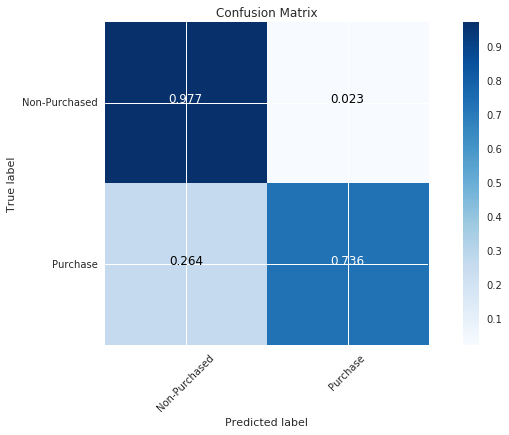

In [42]:
Y_pred = clf.predict(X_test)
# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test, Y_pred))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)

**feature Importance check**

In [43]:
clf.feature_importances_

array([  1.06810603e-02,   1.15615540e-02,   2.10995454e-02,
         4.53261842e-03,   1.33186293e-03,   1.08840357e-02,
         2.25898210e-02,   3.32079631e-02,   4.50639244e-02,
         1.66517271e-02,   1.14692378e-01,   1.24913790e-01,
         1.73717390e-02,   8.86528847e-02,   7.77038264e-02,
         8.03579749e-02,   8.64875080e-04,   5.82248857e-04,
         5.67393132e-04,   1.58981692e-03,   2.18424458e-04,
         2.29760618e-03,   4.05010879e-04,   6.77300787e-04,
         2.25259723e-04,   2.56527719e-04,   2.07517055e-04,
         3.43738865e-02,   4.33211220e-04,   5.16897089e-04,
         2.38957001e-04,   5.65568263e-05,   1.13856968e-04,
         1.27571531e-03,   7.77837299e-05,   1.39013351e-04,
         2.64893118e-03,   1.30930011e-04,   4.13392136e-04,
         6.09643506e-04,   2.44687503e-04,   1.28634614e-03,
         4.38209075e-03,   5.95543283e-04,   1.15528531e-03,
         7.15002465e-03,   5.11914764e-04,   1.93271449e-03,
         3.68996719e-03,

In [44]:
sum(clf.feature_importances_)

0.99999999999999956

### 3.3 ROC AUC

In [50]:
n_classes=1
Y_prob = clf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, Y_prob[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_prob[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

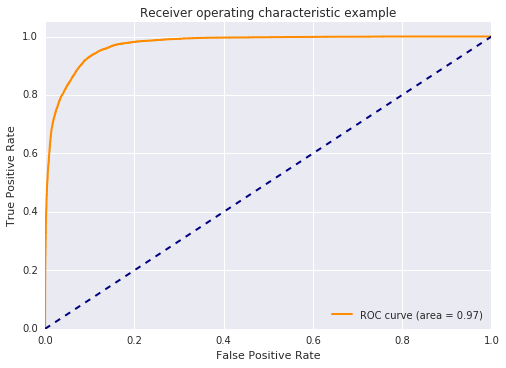

In [51]:
# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


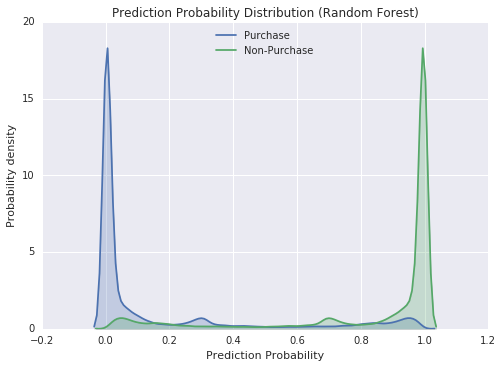

In [23]:
import seaborn as sns
sns.set(color_codes=True)

Y_prob = clf.predict_proba(X_test)

sns.kdeplot(Y_prob[:,1], shade=True, label="Purchase");
sns.kdeplot(Y_prob[:,0], shade=True, label="Non-Purchase");

# sns.kdeplot(Y_prob[:,1], shade=True,cut=0, label="Purchase");
# sns.kdeplot(Y_prob[:,0], shade=True,cut=0,label="Non-Purchase");

plt.xlabel('Prediction Probability')
plt.ylabel('Probability density')
plt.title(r'Prediction Probability Distribution (Random Forest)')

**Feature Importance Plot**

<Container object of 81 artists>

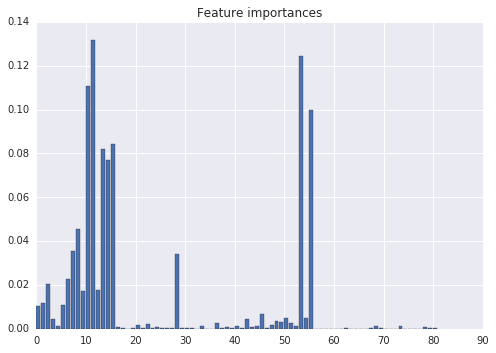

In [25]:
importances=clf.feature_importances_ 
b=importances.reshape(len(importances),1)
a=len(b)

plt.figure()
plt.title("Feature importances")
plt.bar(range(a),b)

In [26]:
min(importances)

2.4551030152497543e-05

---